In [ ]:
'''using torchvision for dataloading'''
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from psutil import cpu_count
from torchvision import transforms
from torch.utils.data import DataLoader
from dataloader import PicklebotDataset, custom_collate
from mobilenet import MobileNetLarge2D, MobileNetSmall2D, MobileNetSmall3D,MobileNetLarge3D
from helpers import calculate_accuracy, initialize_mobilenet_weights

%matplotlib widget

'''strikes are 1, ballss are 2 since we pad with 0s and cross entropy loss has to ignore something.'''

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#hyperparameters
learning_rate = 3e-4 #the paper quotes rmsprop with 0.1 lr, but we have a tiny batch size, and are using AdamW
batch_size = 4 #the paper quotes 128 images/chip, but with video we have to change this
max_iters = 2000
eval_interval = 50
weight_decay = 0.0005
momentum = 0.9
eps = np.sqrt(0.002) #From the pytorch blog post, "a reasonable approximation can be taken with the formula PyTorch_eps = sqrt(TF_eps)."
use_autocast = False

#video paths
train_video_paths = '/workspace/picklebotdataset/train'
val_video_paths = '/workspace/picklebotdataset/val'

#annotations paths
train_annotations_file = '/home/hankhome/Documents/PythonProjects/picklebotdataset/train_labels.csv'
val_annotations_file = '/home/hankhome/Documents/PythonProjects/picklebotdataset/val_labels.csv'

#video paths
train_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/train_all_together'
val_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/val_all_together'

#establish our normalization using transforms
transform = transforms.Normalize((0.5,), (0.5,))

#dataset     
train_dataset = PicklebotDataset(train_annotations_file,train_video_paths,transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count())
val_dataset = PicklebotDataset(val_annotations_file,val_video_paths,transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count())

#model, optimizer, loss function
model = MobileNetSmall3D().to(device)

#initialize weights
initialize_mobilenet_weights(model)

#for multi-gpu
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# optimizer = optim.RMSprop(params=model.parameters(),lr=learning_rate,weight_decay=weight_decay,momentum=momentum,eps=eps) #starting with AdamW for now. 
optimizer = optim.AdamW(params=model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)
scaler = GradScaler()
model_name = 'mobilenetsmall_3D_lambda' 

@torch.no_grad()
def estimate_loss():
    #evaluate the model
    model.eval()
    val_losses = [] 
    correct_predictions = 0

    #calculate the loss
    for val_features,val_labels in val_loader:
        val_features = val_features.to(device)
        val_labels = val_labels.to(torch.int64) #waiting to move to device until after forward pass, idk if this matters
        val_labels = val_labels.expand(val_features.shape[2]) #this is only for our lstm T -> batch size, a lame hack
        
        val_outputs = model(val_features)
        
        val_loss = criterion(val_outputs,val_labels.to(device))
        
        val_losses.append(val_loss.item())
         
        correct_predictions += calculate_accuracy(val_outputs,val_labels)
    
    avg_val_loss = np.mean(val_losses)
    val_accuracy = correct_predictions / len(val_loader.dataset)
    return avg_val_loss, val_accuracy





#try except block so we can manually early stop while saving the model
#training loop
start_time = time.time()
train_losses = []
train_percent = []
val_losses = []
val_percent = []


#plot losses
plt.ion()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.legend()

#plot accuracy
ax2.plot(train_percent, label='Train Accuracy')
ax2.plot(val_percent, label='Val Accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.legend()


try:
    for iter in range(max_iters):
        
        model.train()
        train_correct = 0
        train_samples = 0
        #forward pass
        for batch_idx, (features,labels) in tqdm(enumerate(train_loader)):
            
            labels = labels.to(torch.int64)
            features = features.to(device)
            labels = labels.expand(features.shape[2]) #this is only for our lstm T -> batch size, a lame hack
            
            #zero the gradients
            optimizer.zero_grad(set_to_none=True)
            
            if use_autocast:    
                with autocast():
                    outputs = model(features)
                    loss = criterion(outputs,labels.to(device))
                
                #backprop & update weights

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            else:
                outputs = model(features)
                loss = criterion(outputs,labels.to(device))

                #backprop & update weights
                loss.backward()
                optimizer.step()
            

            batch_correct = calculate_accuracy(outputs,labels)
            train_correct += batch_correct
            train_samples += len(labels)
            train_losses.append(loss.item())

        if iter % eval_interval == 0 or iter == max_iters - 1:
            
            #evaluate the model
            avg_train_loss = np.mean(train_losses)
            train_percent.append(train_correct / train_samples)
            val_loss, val_accuracy = estimate_loss()
        
            val_losses.append(val_loss) #loss of the val batch
            val_percent.append(val_accuracy) #percent of correct predictions in the val batch

            print(f"step {iter}: train loss:  {avg_train_loss:.4f}, val loss: {val_loss:.4f}")
            print(f"step {iter}: train accuracy:  {train_percent[-1]*100:.2f}%, val accuracy: {val_percent[-1]*100:.2f}%")

            # #plot the losses
            ax1.plot(train_losses, label='Train Loss')
            ax1.plot(val_losses, label='Val Loss')

            #plot the accuracy
            ax2.plot(train_percent, label='Train Accuracy')
            ax2.plot(val_percent, label='Val Accuracy')


            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(0.001)


        elapsed = time.time() - start_time
        remaining_iters = max_iters - iter
        avg_time_per_iter = elapsed / (iter + 1)
        estimated_remaining_time = remaining_iters * avg_time_per_iter

        tqdm.write(f"Iter [{iter+1}/{max_iters}] - Elapsed Time: {elapsed:.2f}s  Remaining Time: [{estimated_remaining_time:.2f}]")
        if iter == max_iters -1:
            print("Training completed:") 
            print(f"Final train loss: {train_losses[-1]:.4f},")
            print(f"Final val loss: {val_losses[-1]:.4f}, ")
            print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
            print(f"Final val accuracy: {val_percent[-1]*100:.2f}%") 
            
except KeyboardInterrupt:
    print(f"Keyboard interrupt,\nFinal train loss: {train_losses[-1]:.4f}, ")
    print(f"Final val loss: {val_losses[-1]:.4f}, ")
    print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
    print(f"Final val accuracy: {val_percent[-1]*100:.2f}%")

finally:
    torch.save(model.state_dict(), f'{model_name}.pth')
    with open(f'{model_name}_train_losses.npy', 'wb') as f:
        np.save(f, np.array(train_losses))
    with open(f'{model_name}_val_losses.npy', 'wb') as f:
        np.save(f, np.array(val_losses))
    with open(f'{model_name}_train_percent.npy', 'wb') as f:
        np.save(f, np.array(train_percent))
    with open(f'{model_name}_val_percent.npy', 'wb') as f:
        np.save(f, np.array(val_percent))
    print(f"Model saved!") 
plt.ioff()

/home/hankhome/mambaforge/lib/python3.10/site-packages/nvidia/dali/plugin/base_iterator.py:191: Warning: Please set `reader_name` and don't set last_batch_padded and size manually whenever possible. This may lead, in some situations, to missing some samples or returning duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()
4it [00:09,  2.38s/it]


Iter [1/200] - Elapsed Time: 9.67s  Remaining Time: [1933.82]


4it [00:09,  2.38s/it]


Iter [2/200] - Elapsed Time: 19.17s  Remaining Time: [1907.63]


4it [00:09,  2.47s/it]


Iter [3/200] - Elapsed Time: 29.04s  Remaining Time: [1916.72]


4it [00:09,  2.41s/it]


Iter [4/200] - Elapsed Time: 38.70s  Remaining Time: [1905.90]


4it [00:09,  2.39s/it]


Iter [5/200] - Elapsed Time: 48.25s  Remaining Time: [1891.55]


4it [00:09,  2.34s/it]


Iter [6/200] - Elapsed Time: 57.61s  Remaining Time: [1872.35]


4it [00:09,  2.45s/it]


Iter [7/200] - Elapsed Time: 67.41s  Remaining Time: [1868.14]


4it [00:09,  2.29s/it]


Iter [8/200] - Elapsed Time: 76.58s  Remaining Time: [1847.45]


4it [00:09,  2.50s/it]


Iter [9/200] - Elapsed Time: 86.58s  Remaining Time: [1846.94]


4it [00:11,  2.81s/it]


Iter [10/200] - Elapsed Time: 97.82s  Remaining Time: [1868.37]


4it [00:10,  2.66s/it]


Iter [11/200] - Elapsed Time: 108.48s  Remaining Time: [1873.66]


4it [00:11,  2.92s/it]


Iter [12/200] - Elapsed Time: 120.15s  Remaining Time: [1892.34]


4it [00:11,  2.90s/it]


Iter [13/200] - Elapsed Time: 131.77s  Remaining Time: [1905.62]


4it [00:11,  2.86s/it]


Iter [14/200] - Elapsed Time: 143.23s  Remaining Time: [1913.21]


4it [00:11,  2.80s/it]


Iter [15/200] - Elapsed Time: 154.43s  Remaining Time: [1914.91]


4it [00:11,  2.97s/it]


Iter [16/200] - Elapsed Time: 166.30s  Remaining Time: [1922.80]


4it [00:12,  3.07s/it]


Iter [17/200] - Elapsed Time: 178.57s  Remaining Time: [1932.80]


4it [00:11,  2.88s/it]


Iter [18/200] - Elapsed Time: 190.09s  Remaining Time: [1932.58]


4it [00:11,  2.79s/it]


Iter [19/200] - Elapsed Time: 201.26s  Remaining Time: [1927.88]


4it [00:10,  2.50s/it]


Iter [20/200] - Elapsed Time: 211.28s  Remaining Time: [1912.12]


4it [00:09,  2.44s/it]


Iter [21/200] - Elapsed Time: 221.06s  Remaining Time: [1894.83]


4it [00:09,  2.37s/it]


Iter [22/200] - Elapsed Time: 230.56s  Remaining Time: [1875.89]


4it [00:09,  2.43s/it]


Iter [23/200] - Elapsed Time: 240.27s  Remaining Time: [1859.50]


4it [00:09,  2.33s/it]


Iter [24/200] - Elapsed Time: 249.61s  Remaining Time: [1840.90]


4it [00:09,  2.30s/it]


Iter [25/200] - Elapsed Time: 258.80s  Remaining Time: [1821.97]


4it [00:09,  2.32s/it]


Iter [26/200] - Elapsed Time: 268.07s  Remaining Time: [1804.34]


4it [00:09,  2.27s/it]


Iter [27/200] - Elapsed Time: 277.16s  Remaining Time: [1786.11]


4it [00:09,  2.28s/it]


Iter [28/200] - Elapsed Time: 286.29s  Remaining Time: [1768.89]


4it [00:08,  2.24s/it]


Iter [29/200] - Elapsed Time: 295.24s  Remaining Time: [1751.10]


4it [00:09,  2.26s/it]


Iter [30/200] - Elapsed Time: 304.31s  Remaining Time: [1734.54]


4it [00:09,  2.31s/it]


Iter [31/200] - Elapsed Time: 313.55s  Remaining Time: [1719.48]


4it [00:09,  2.30s/it]


Iter [32/200] - Elapsed Time: 322.76s  Remaining Time: [1704.56]


4it [00:09,  2.30s/it]


Iter [33/200] - Elapsed Time: 331.95s  Remaining Time: [1689.94]


4it [00:09,  2.39s/it]


Iter [34/200] - Elapsed Time: 341.53s  Remaining Time: [1677.50]


4it [00:09,  2.28s/it]


Iter [35/200] - Elapsed Time: 350.63s  Remaining Time: [1663.00]


4it [00:09,  2.28s/it]


Iter [36/200] - Elapsed Time: 359.77s  Remaining Time: [1648.95]


4it [00:09,  2.27s/it]


Iter [37/200] - Elapsed Time: 368.86s  Remaining Time: [1634.93]


4it [00:09,  2.30s/it]


Iter [38/200] - Elapsed Time: 378.05s  Remaining Time: [1621.65]


4it [00:09,  2.39s/it]


Iter [39/200] - Elapsed Time: 387.63s  Remaining Time: [1610.14]


4it [00:09,  2.45s/it]


Iter [40/200] - Elapsed Time: 397.43s  Remaining Time: [1599.67]


4it [00:09,  2.46s/it]


Iter [41/200] - Elapsed Time: 407.28s  Remaining Time: [1589.38]


4it [00:09,  2.41s/it]


Iter [42/200] - Elapsed Time: 416.91s  Remaining Time: [1578.29]


4it [00:09,  2.36s/it]


Iter [43/200] - Elapsed Time: 426.33s  Remaining Time: [1566.53]


4it [00:09,  2.25s/it]


Iter [44/200] - Elapsed Time: 435.34s  Remaining Time: [1553.38]


4it [00:09,  2.27s/it]


Iter [45/200] - Elapsed Time: 444.41s  Remaining Time: [1540.62]


4it [00:09,  2.27s/it]


Iter [46/200] - Elapsed Time: 453.47s  Remaining Time: [1528.01]


4it [00:09,  2.45s/it]


Iter [47/200] - Elapsed Time: 463.27s  Remaining Time: [1517.96]


4it [00:09,  2.45s/it]


Iter [48/200] - Elapsed Time: 473.07s  Remaining Time: [1507.91]


4it [00:10,  2.55s/it]


Iter [49/200] - Elapsed Time: 483.29s  Remaining Time: [1499.19]


4it [00:09,  2.45s/it]
4it [00:05,  1.37s/it]


step 49: train loss:  nan, val loss: nan
step 49: train accuracy:  50.00%, val accuracy: 37.50%
Model saved!


AttributeError: 'list' object has no attribute 'view'

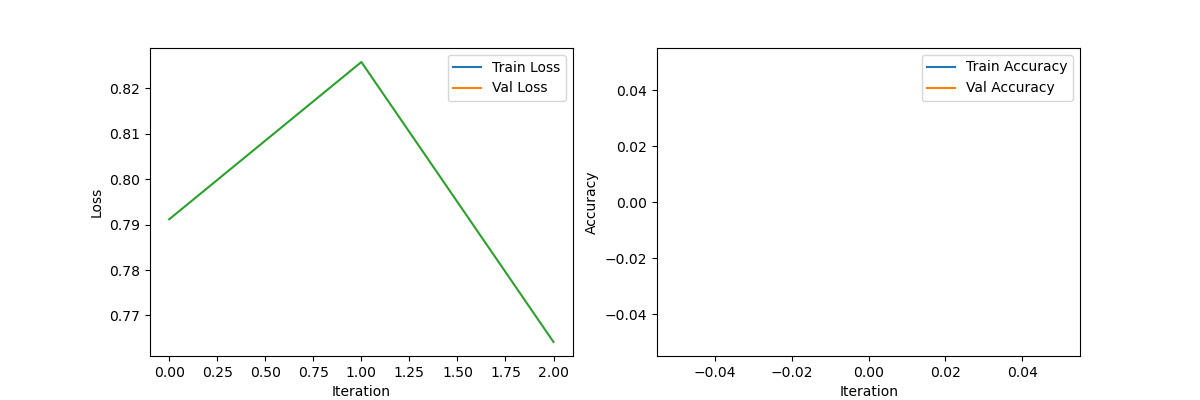

In [6]:
'''This version of the program uses Nvidia Dali to load data, not torchvision.io.read_video,
   It should be substantially faster, especially with multiple gpus, perhaps a good setup 
   would be one to load the videos, one to run the training loop? Perhaps not as I learned more about it.

    Eventually, this and the other version in this notebook should be merged into one notebook, with a flag to choose which to use.
   
'''
import os
import torch
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from nvidia.dali.plugin.pytorch import DALIClassificationIterator, LastBatchPolicy
from tqdm import tqdm
from psutil import cpu_count
from mobilenet import MobileNetLarge2D, MobileNetSmall2D, MobileNetSmall3D,MobileNetLarge3D
from helpers import calculate_accuracy, initialize_mobilenet_weights, video_pipeline

%matplotlib widget

'''
Our mean is ([0.3939, 0.3817, 0.3314])
Our std is ([0.2104, 0.1986, 0.1829])
'''



'''Strikes are 0, balls 1 we will eventually pad with 2 or something so cross entropy loss can ignore it, not 0.'''

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#hyperparameters
learning_rate = 1e-3 #the paper quotes rmsprop with 0.1 lr, but we have a tiny batch size, and are using AdamW
batch_size = 2 #the paper quotes 128 images/chip, but with video we have to change this
max_iters = 200
eval_interval = 50
weight_decay = 0.0005
momentum = 0.9
eps = np.sqrt(0.002) #From the pytorch blog post, "a reasonable approximation can be taken with the formula PyTorch_eps = sqrt(TF_eps)."
std = torch.tensor([0.2104*255, 0.1986*255, 0.1829*255])[None,None,None,:]
mean = torch.tensor([0.3939*255, 0.3817*255, 0.3314*255])[None,None,None,:]
use_autocast = True
compile = False

#information for the dali pipeline
sequence_length = 276 #longest videos in our dataset
initial_prefetch_size = 1000

#video paths
train_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/train_test'
val_video_paths = '/home/hankhome/Documents/PythonProjects/picklebotdataset/val_test'
num_train_videos = len(os.listdir(train_video_paths + '/' + 'balls')) + len(os.listdir(train_video_paths + '/' + 'strikes'))
num_val_videos = len(os.listdir(val_video_paths + '/' + 'balls')) + len(os.listdir(val_video_paths + '/' + 'strikes'))
#define our model, initialize
model = MobileNetSmall3D().to(device)
# initialize_mobilenet_weights(model)

#for multi-gpu setups 
#may want to revisit this and choose which device we use for loading with dali, and which to use for training the net.
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

#define our optimizer
#optimizer = optim.RMSprop(params=model.parameters(),lr=learning_rate,weight_decay=weight_decay,momentum=momentum,eps=eps) #starting with AdamW for now. 
optimizer = optim.AdamW(params=model.parameters(),lr=learning_rate,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss() #we'll want to add back in ignoring the padding
scaler = GradScaler()
model_name = 'mobilenetsmall_3D_cloud' 


if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model)  # requires PyTorch 2.0

#estimate_loss using validation set, we should refactor this.
@torch.no_grad()
def estimate_loss():
    #evaluate the model
    model.eval()
    val_losses = []
    val_correct = 0
    val_samples = 0

    #calculate the loss
    for _,val_features in tqdm(enumerate(val_loader)):
        val_labels = (val_features[0]['label']).view(-1).long() #need this as a (batch_size,) tensor
        val_features = val_features[0]['data']/255
        val_features = (val_features-mean.to(device))/std.to(device) #normalize
        val_features = val_features.permute(0,-1,1,2,3) 
        # val_labels = val_labels.expand(val_features.shape[2]) #this is only for our lstm T -> batch size, a lame hack

        val_outputs = model(val_features)
        
        val_loss = criterion(val_outputs,val_labels)
        
        val_losses.append(val_loss.item())  
        
        val_correct += calculate_accuracy(val_outputs,val_labels) #get number of correct
        val_samples += len(labels) #this is the total number of samples so far

    avg_val_loss = np.mean(val_losses)
    val_accuracy = val_correct / val_samples
    return avg_val_loss, val_accuracy


#initialize lists for plotting
start_time = time.time()
train_losses = []
train_percent = []
val_losses = []
val_percent = []

#plot losses
plt.ion()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.legend()

#plot accuracy
ax2.plot(train_percent, label='Train Accuracy')
ax2.plot(val_percent, label='Val Accuracy')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.legend()

#build our pipelines
train_pipe = video_pipeline(batch_size=batch_size, num_threads=cpu_count(), device_id=0, file_root=train_video_paths,
                            sequence_length=sequence_length,initial_prefetch_size=initial_prefetch_size)
val_pipe = video_pipeline(batch_size=batch_size, num_threads=cpu_count(), device_id=0, file_root=val_video_paths,
                          sequence_length=sequence_length,initial_prefetch_size=initial_prefetch_size)

train_pipe.build()
val_pipe.build()


train_loader = DALIClassificationIterator(train_pipe, auto_reset=True,last_batch_policy=LastBatchPolicy.PARTIAL, size=num_train_videos)
val_loader = DALIClassificationIterator(train_pipe, auto_reset=True,last_batch_policy=LastBatchPolicy.PARTIAL, size=num_train_videos)

try:
    for iter in range(max_iters):
        
        model.train()
        train_correct = 0
        train_samples = 0
        batch_loss_list = [] #want to overwrite this each epoch
        
        #forward pass
        for batch_idx, features in tqdm(enumerate(train_loader)):
            
            labels = (features[0]['label']).view(-1).long() #need this as a (batch_size,) tensor in int64
            features = features[0]['data']/255 #i think it makes sense to overwrite features to save precious gpu memory
            features = (features-mean.to(device))/std.to(device) #normalize


            features = features.permute(0,-1,1,2,3)
            # labels = labels.expand(features.shape[2]) #this is only for our lstm T -> batch size, a lame hack
            
            #zero the gradients
            optimizer.zero_grad(set_to_none=True)
            
            if use_autocast:    
                with autocast():
                    outputs = model(features)
                    loss = criterion(outputs,labels)
                
                #backprop & update weights

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            else:
                outputs = model(features)
                loss = criterion(outputs,labels)

                #backprop & update weights
                loss.backward()
                optimizer.step()
        
            batch_loss_list.append(loss.item()) #append the loss of the batch to our list to be averaged and plotted later, this is dataset size / batch size long
            batch_correct = calculate_accuracy(outputs,labels) #number of correct predictions in the batch
            train_correct += batch_correct #this is the total number of correct predictions so far
            train_samples += len(labels) #this is the total number of samples so far


        train_losses.append(np.mean(batch_loss_list))
        train_percent.append(train_correct / train_samples)
        elapsed = time.time() - start_time
        remaining_iters = max_iters - iter
        avg_time_per_iter = elapsed / (iter + 1)
        estimated_remaining_time = remaining_iters * avg_time_per_iter

        if iter != 0 and ((iter+1) % eval_interval == 0 or iter == max_iters - 1):
            
            #evaluate the model
            val_loss, val_accuracy = estimate_loss()
        
            val_losses.append(val_loss) #loss of the val set
            val_percent.append(val_accuracy) #percent of correct predictions in the val set


            print(f"step {iter}: train loss:  {train_losses[-1]:.4f}, val loss: {val_loss:.4f}")
            print(f"step {iter}: train accuracy:  {train_percent[-1]*100:.2f}%, val accuracy: {val_percent[-1]*100:.2f}%")

            # #plot the losses
            ax1.plot(torch.tensor(train_losses).view(-1,10).mean(1), label='Train Loss')
            ax1.plot(torch.tensor(val_losses).view(-1,1).mean(1), label='Val Loss')

            #plot the accuracy
            ax2.plot(torch.tensor(train_percent).view(-1,10).mean(1), label='Train Accuracy')
            ax2.plot(torch.tensor(val_percent).view(-1,1).mean(1), label='Val Accuracy')


            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(0.001)

        tqdm.write(f"Iter [{iter+1}/{max_iters}] - Elapsed Time: {elapsed:.2f}s  Remaining Time: [{estimated_remaining_time:.2f}]")
        if iter == max_iters -1:
            print("Training completed:") 
            print(f"Final train loss: {train_losses[-1]:.4f},")
            print(f"Final val loss: {val_losses[-1]:.4f}, ")
            print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
            print(f"Final val accuracy: {val_percent[-1]*100:.2f}%") 
            
except KeyboardInterrupt:
    print(f"Keyboard interrupt,\nFinal train loss: {train_losses[-1]:.4f}, ")
    print(f"Final val loss: {val_losses[-1]:.4f}, ")
    print(f"Final train accuracy: {train_percent[-1]*100:.2f}%, ")
    print(f"Final val accuracy: {val_percent[-1]*100:.2f}%")

finally:
    torch.save(model.state_dict(), f'{model_name}.pth')
    with open(f'{model_name}_train_losses.npy', 'wb') as f:
        np.save(f, np.array(train_losses))
    with open(f'{model_name}_val_losses.npy', 'wb') as f:
        np.save(f, np.array(val_losses))
    with open(f'{model_name}_train_percent.npy', 'wb') as f:
        np.save(f, np.array(train_percent))
    with open(f'{model_name}_val_percent.npy', 'wb') as f:
        np.save(f, np.array(val_percent))
    print(f"Model saved!") 
plt.ioff()

In [2]:
#unnormalized stuff
unnormalized_train_losses = train_losses
unnormalized_val_losses = val_losses
unnormalized_train_percent = train_percent
unnormalized_val_percent = val_percent


In [4]:
#normalized stuff
normalized_train_losses = train_losses
normalized_train_percent = train_percent
normalized_val_losses = val_losses
normalized_val_percent = val_percent